# Rewriting a Deep Generative Models

Rewriting single weights of convolutional generators to add new key-value pair as new rules.

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import tqdm

In [3]:
from utils import nethook
from utils.runningstats import RunningCovariance
from utils.seqstylegan2 import SeqStyleGAN2

## Prepare

Prepare stylegan generator.

In [4]:
device = torch.device('cuda')
IMG_SIZE = 256
LATENT_DIM = 512

In [5]:
# Load sequential stylegan2
stylegan = SeqStyleGAN2(
    size=IMG_SIZE, style_dim=LATENT_DIM, n_mlp=8, truncation=1, mconv='seq')
stylegan.to(device)
_ = stylegan.requires_grad_(False)

In [6]:
# Load checkpoint
ckpt = torch.load('./release/stylegan2-church-config-f.pt')
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [7]:
# target feature map
target_layer = 8

# layer name
target_first = 'layer{}.sconv.mconv.dconv'.format(target_layer)
target_last = 'layer{}.sconv.activate'.format(target_layer)

# split
context_model = nethook.subsequence(
    stylegan,
    upto_layer=target_first,
    share_weights=True)
target_model = nethook.subsequence(
    stylegan,
    first_layer=target_first,
    last_layer=target_last,
    share_weights=True)
render_model = nethook.subsequence(
    stylegan,
    after_layer=target_last,
    share_weights=True)

In [8]:
def postproc(sample):
    """Postprocessor, min-max normalization, BHWC permutation.
    Args:
        sample: torch.Tensor, [B, C, H, W], generated image.
    Returns:
        np.ndarray, [B, H, W, C], normalized image in range [0, 1].
    """
    sample = sample.permute(0, 2, 3, 1).cpu().detach().numpy()
    min_ = sample.min(axis=(1, 2, 3), keepdims=True)
    max_ = sample.max(axis=(1, 2, 3), keepdims=True)
    sample = (sample - min_) / (max_ - min_)
    return sample

In [9]:
def show(sample, row=2, size=5):
    bsize = len(sample)
    plt.figure(figsize=(bsize // row * size, row * size))
    for i in range(bsize):
        plt.subplot(row, bsize // row, i + 1)
        plt.imshow(sample[i])

## Context images 

Pre-sampled context images for computing key-covariance.

In [10]:
# latents
zdump = np.load('./dataset/zdump.npy', allow_pickle=True).item()
z = torch.tensor(zdump['z'], device=device)
z.shape

torch.Size([8, 512])

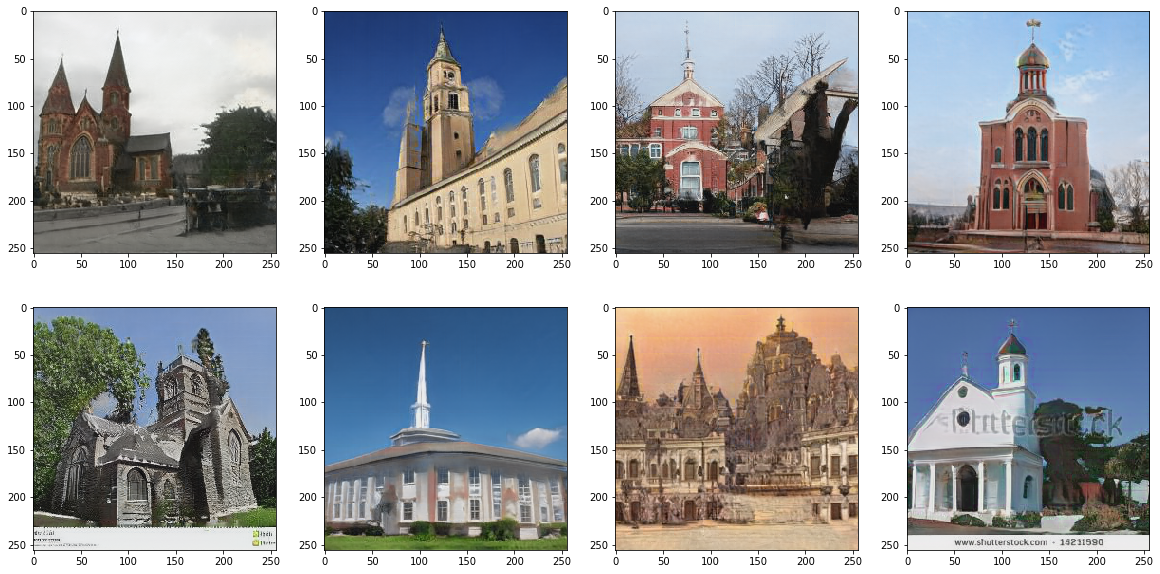

In [11]:
# key images
context = context_model(z)
sample = postproc(render_model(target_model(context)))
show(sample)

## Compute covariance

Compute covariance matrix with utis, RunningCovariance.

In [12]:
subbatch = 32
num_sample = 1000

zs = torch.randn(num_sample, LATENT_DIM, device=device)
stats = RunningCovariance()

for i in range(num_sample // subbatch):
    keys = context_model(zs[i * subbatch:(i + 1) * subbatch]).fmap
    keys = keys.permute(0, 2, 3, 1).reshape(-1, LATENT_DIM)
    stats.add(keys)

mean, cov = stats.mean(), stats.covariance()

## ZCA-Whitened covariance

Compute ZCA-matrix for computing whitened direction vectors.

In [13]:
# C = USU^T => Z = C^{-1} = US^{-1/2}U^T
evals, evecs = torch.symeig(cov.double(), eigenvectors=True)
zca = evecs @ torch.diag(1 / evals.sqrt().clamp_min(1e-20)) @ evecs.T
zca = zca.float()
zca.shape

torch.Size([512, 512])

## Prepare key-masks

Import pre-processed key-masks

In [14]:
maskdir = './dataset/masks_proc'
masks = np.stack([plt.imread(os.path.join(maskdir, fname)) for fname in os.listdir(maskdir) if 'value' not in fname])
masks = torch.tensor(masks, dtype=torch.float, device=device) / 255.
masks.shape

torch.Size([8, 256, 256])

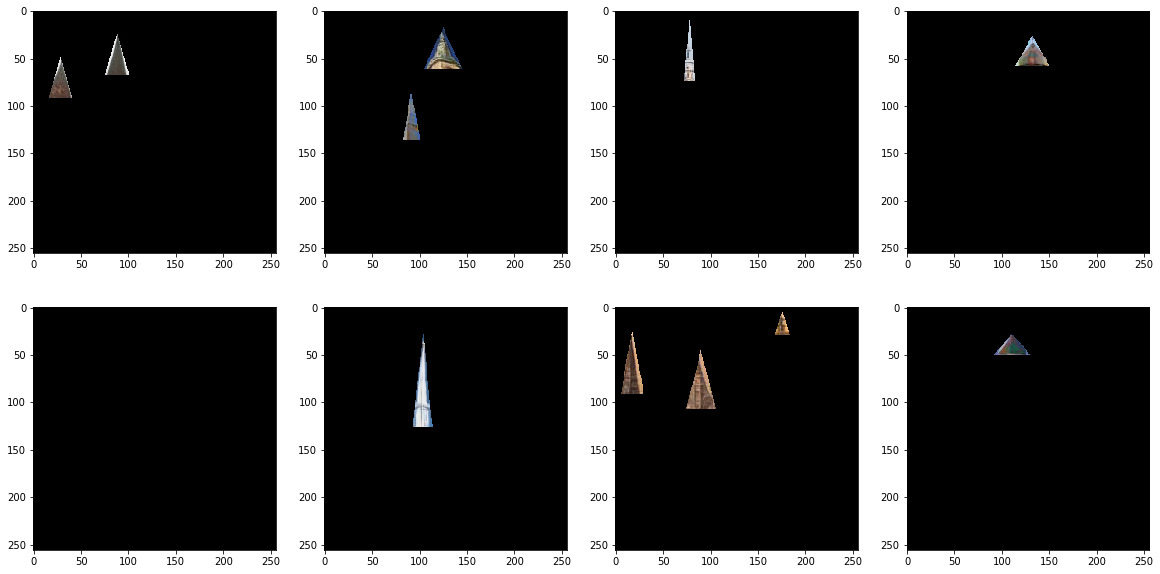

In [15]:
show(sample * masks.cpu().detach().numpy()[..., None])

## Compute ZCA-whitened directions

Reference Appendix.D.


In [16]:
# by feature indepdency, mask can be directly interpolate to feature map size.
context_masks = F.interpolate(masks[:, None], context.fmap.shape[2:], mode='bilinear')
context_masks.shape

torch.Size([8, 1, 32, 32])

In [17]:
channels = context.fmap.shape[1]
weights = context_masks.view(-1)
keys = context.fmap.permute(0, 2, 3, 1).reshape(-1, channels)
masked_keys = (weights[:, None] * (zca @ keys.T).T)[weights > 0]
masked_keys.shape

torch.Size([192, 512])

In [18]:
# [latent_dim, B]
_, _, q = masked_keys.svd()
# [latent_dim, rank]
rank = 1
evecs = q[:, :rank]
# [rank, latent_dim]
rowdirs = (zca @ evecs).T
# [latent_dim]
avg = masked_keys.sum(0)
# [latent_dim, rank], [rank, rank]
q, r = torch.qr(rowdirs.T)
# [rank]
signs = (q * avg[:, None]).sum(0).sign()
# [latent_dim, rank]
q = q * signs[None]
# [rank, latent_dim]
basis = q.T
basis.shape

torch.Size([1, 512])

## Generate target value

Directly copy feature map to paste point

In [19]:
keyidx = 7
valueidx = 0

In [20]:
# generate sample key, value
input_key = context_model(z[keyidx:keyidx + 1])
input_value = target_model(input_key)
target_value = target_model(context_model(z[valueidx:valueidx + 1]))
input_key.fmap.shape, input_value.fmap.shape, target_value.fmap.shape

(torch.Size([1, 512, 32, 32]),
 torch.Size([1, 512, 32, 32]),
 torch.Size([1, 512, 32, 32]))

In [21]:
key_mask = context_masks[keyidx:keyidx + 1]
key_mask.shape

torch.Size([1, 1, 32, 32])

In [22]:
# load value mask (copied point)
value_mask = plt.imread('./dataset/masks_proc/mask_value_resized.jpg').astype(np.float32) / 255.
value_mask = torch.tensor(value_mask, device=device)
value_mask = F.interpolate(value_mask[None, None], target_value.fmap.shape[2:], mode='bilinear')
value_mask.shape

torch.Size([1, 1, 32, 32])

In [23]:
def bbox_from_mask(mask):
    coords = (mask > 0).nonzero()
    top, bottom = coords[:, 2].min(), coords[:, 2].max()
    left, right = coords[:, 3].min(), coords[:, 3].max()
    return top, bottom, left, right

In [24]:
def matching_center(vbox, kbox):
    tv, bv, lv, rv = vbox
    tk, bk, lk, rk = kbox
    center_h = (tk + bk) // 2
    center_w = (lk + rk) // 2
    tm, bm = center_h - (bv - tv) // 2, center_h + (bv - tv) // 2
    lm, rm = center_w - (rv - lv) // 2, center_w + (rv - lv) // 2
    if bm - tm != bv - tv:
        bm += 1
    if rm - lm != rv - lv:
        rm += 1
    return tm, bm, lm, rm

In [25]:
def move_object(value, prev_box, new_box, interp=True):
    tp, bp, lp, rp = prev_box
    tn, bn, ln, rn = new_box
    newone = torch.zeros_like(value)
    if interp:
        newone[..., tn:bn, ln:rn] = F.interpolate(value[..., tp:bp, lp:rp], (bn - tn, rn - ln), mode='nearest')
    else:
        tm, bm, lm, rm = matching_center(prev_box, new_box)
        newone[..., tm:bm, lm:rm] = value[..., tp:bp, lp:rp]
    return newone

In [26]:
vbox = bbox_from_mask(value_mask)
kbox = bbox_from_mask(context_masks[keyidx:keyidx + 1])
moved_mask = move_object(value_mask, vbox, kbox, interp=False)

In [27]:
# paste copied point
moved_value = move_object(target_value.fmap, vbox, kbox, interp=False)
target_value = type(input_value)({ k: v.detach() for k, v in input_value.items() })
target_value.fmap = input_value.fmap * (1. - moved_mask) + moved_value * moved_mask
target_value.fmap.shape

torch.Size([1, 512, 32, 32])

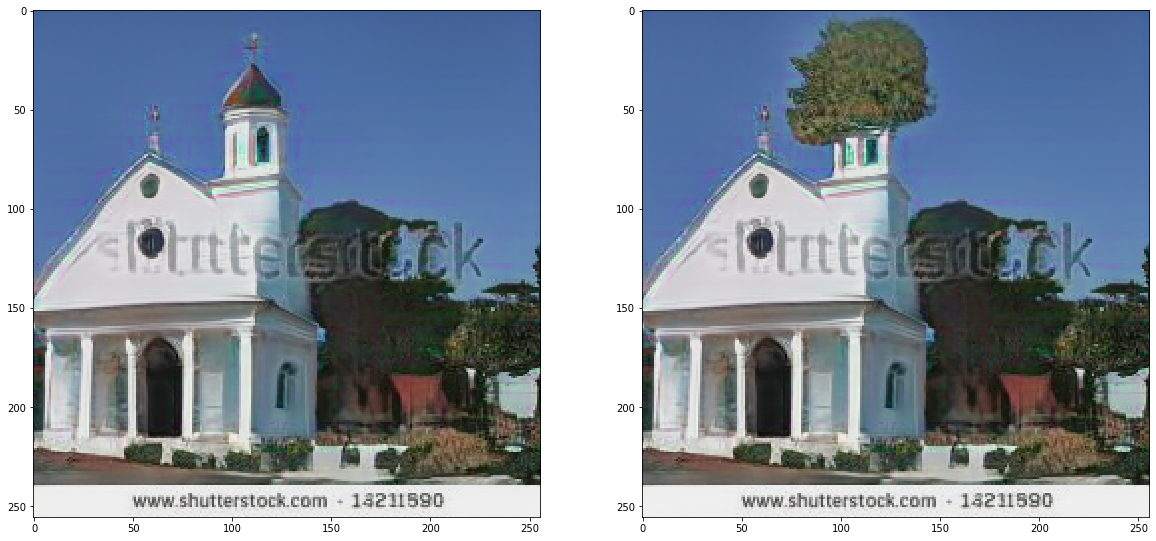

In [28]:
# target image
rendered_origin = render_model(input_value)
rendered_target = render_model(target_value)
rendered = torch.cat([rendered_origin, rendered_target])
show(postproc(rendered), row=1, size=10)

## Prepare optimization

Compute orthogonal weights

In [29]:
def proj(weights, basis):
    """
    Args:
        mat: torch.Tensor, [G, B, C, H, W], matrix.
        basis: torch.Tensor, [R, C], low-rank basis.
    Returns:
        torch.Tensor, [G, B, C, H, W], projected matrix.
    """
    dotprod = torch.einsum('goiyx, ri -> goryx', weights, basis)
    return torch.einsum('goryx, ri -> goiyx', dotprod, basis)

In [30]:
weights = next(param for name, param in target_model.named_parameters() if 'dconv' in name)
weights.requires_grad_()
weights.shape

torch.Size([1, 512, 512, 3, 3])

In [31]:
with torch.no_grad():
    ortho_weights = weights - proj(weights, basis)
ortho_weights.shape

torch.Size([1, 512, 512, 3, 3])

## Optimization

Optimize steps and project to basis

In [32]:
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [33]:
lr = 0.8
steps = 2500
grad_steps = 10

grad_proj = False
weights_proj = True

In [34]:
losses = []
optim = torch.optim.Adam([weights], lr=lr)
for i in tqdm.tqdm(range(steps)):
    optim.zero_grad()
    loss = F.l1_loss(target_value.fmap, target_model(input_key).fmap)
    loss.backward()
    if grad_proj:
        weights.grad[...] = proj(weights.grad, basis)
    optim.step()

    if weights_proj and i % grad_steps == 0:
        with torch.no_grad():
            weights[...] = ortho_weights + proj(weights, basis)
    
    losses.append(loss.cpu().detach().numpy())

100%|██████████| 2500/2500 [00:12<00:00, 201.36it/s]


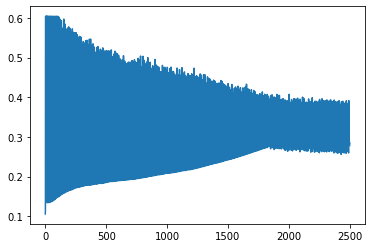

In [35]:
losses = np.array(losses)
mean, std = losses.mean(), losses.std()
losses = np.clip(losses, mean - 2 * std, mean + 2 * std)
plt.plot(losses)

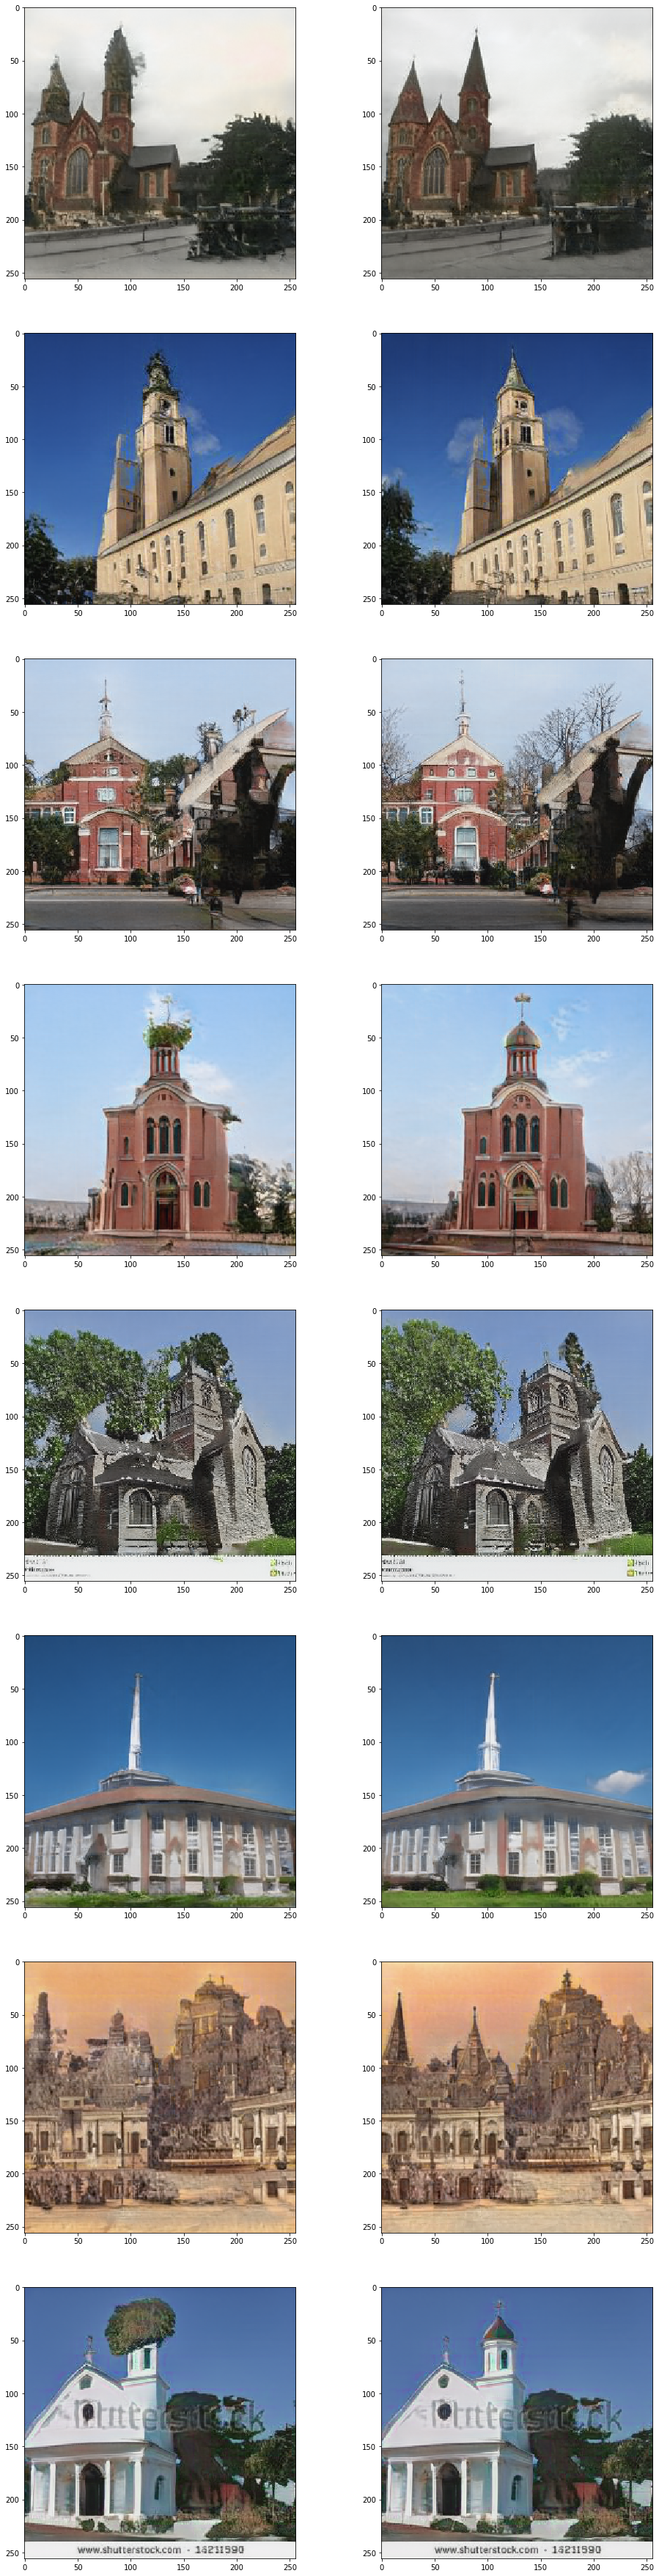

In [36]:
out = postproc(render_model(target_model(context)))

comp = np.zeros((16, 256, 256, 3))
comp[0::2] = out
comp[1::2] = sample
show(comp, row=8, size=8)